In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
from scipy import signal
from scipy.interpolate import griddata

import sys
sys.path.append("/home/j/j_mens07/phd/NanoNets/src/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/NanoNets/src/")
import nanonets_utils
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
%matplotlib inline

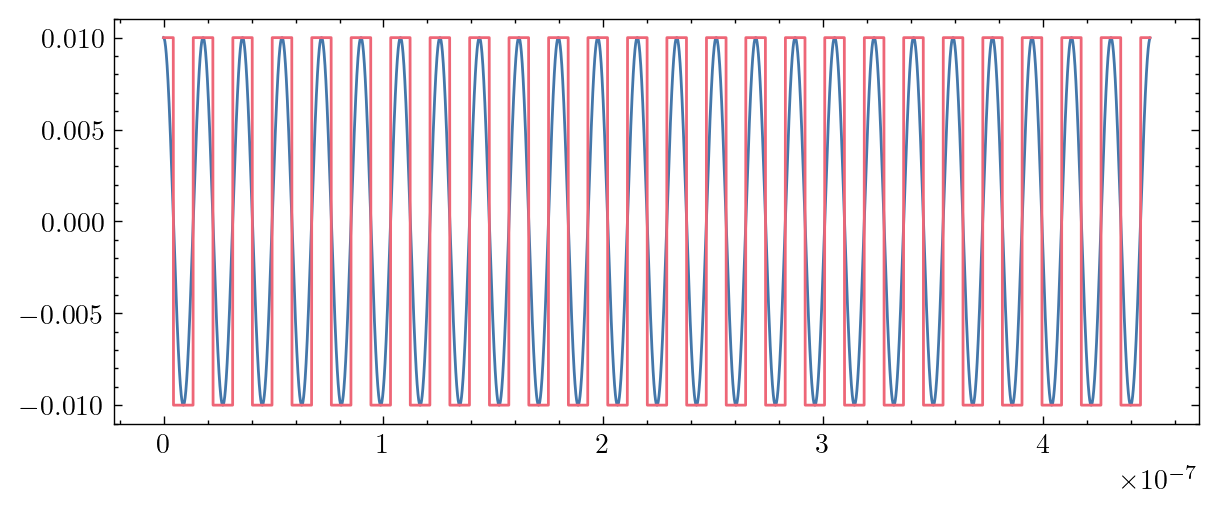

In [133]:
amplitude   = 0.01
freq        = 3.5
time_step   = 1e-10
N_periods   = 50
N_voltages  = int(N_periods*np.pi/(freq*1e8*time_step))
time_steps  = time_step*np.arange(N_voltages)
x_vals      = amplitude*np.cos(freq*time_steps*1e8)
y_target    = amplitude*signal.square(freq*time_steps*1e8-3*np.pi/2)
x_scaled    = (x_vals-np.mean(x_vals))/np.std(x_vals)
y_scaled    = (y_target-np.mean(y_target))/np.std(y_target)

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot()
    ax.plot(time_steps, x_vals)
    ax.plot(time_steps, y_target)

In [226]:
results = pd.DataFrame()
errors  = pd.DataFrame()
n_vals  = 1000
s_type  = 'phase'
volt    = []

n = 0
for i in range(10):
    for j in range(50):
        df_tmp              = pd.read_csv(f"../data/lhs_sample/{s_type}/Nx=7_Ny=7_Nz=1_Ne=8_{i}_{j}.csv")
        results.loc[:,n]    = df_tmp.iloc[:,-2].reset_index(drop=True)
        errors.loc[:,n]     = df_tmp.iloc[:,-1].reset_index(drop=True)
        n                   = n + 1
        volt.append(df_tmp.iloc[:,1:7])

results_norm    = (results.iloc[-1000:,:]-results.iloc[-1000:,:].mean())/results.iloc[-1000,:].std()
results_norm    = 2*(results_norm - results_norm.min())/(results_norm.max()-results_norm.min())-1
results_norm    = results_norm.round(4).reset_index(drop=True)
mse             = np.sqrt(np.mean((results_norm - y_scaled[-n_vals:,np.newaxis])**2, axis=0))
min_val         = np.argmin(mse)

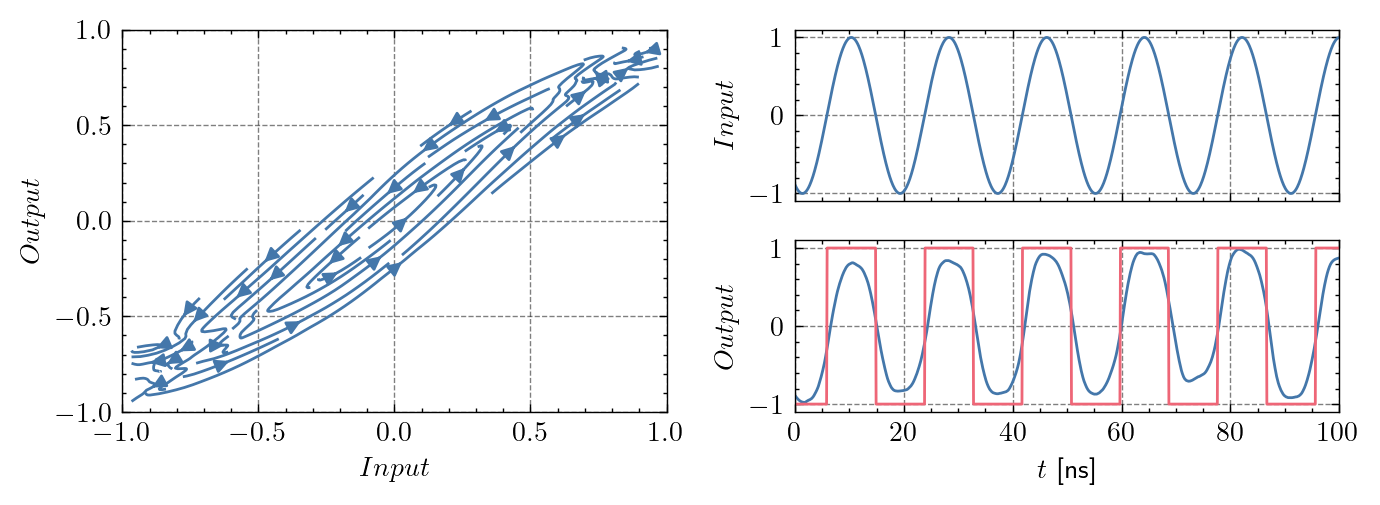

In [227]:
t       = time_steps[:n_vals]*1e9
x       = x_scaled[-n_vals:]
x       = 2*(x - np.min(x))/(np.max(x)-np.min(x)) - 1
y       = signal.savgol_filter(results_norm[min_val], window_length=31, polyorder=3)
# y       = results_norm[min_val]
y_t     = y_scaled[-n_vals:]

dx_dt   = np.gradient(x, t)
dy_dt   = np.gradient(y, t)
X, Y    = np.meshgrid(np.linspace(np.min(x), np.max(x), 100),
                      np.linspace(np.min(y), np.max(y), 100))
points = np.array([x, y]).T

U = griddata(points, dx_dt, (X, Y), method='linear')
V = griddata(points, dy_dt, (X, Y), method='linear')
U = np.ma.masked_invalid(U)
V = np.ma.masked_invalid(V)

with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200, layout='tight')
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot(1,2,1)
    ax.streamplot(X, Y, U, V, density=2)
    # ax.streamplot(X, Y, U, V, density=2, start_points=[[0,0]])
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel("$Input$")
    ax.set_ylabel("$Output$")

    ax  = fig.add_subplot(2,2,2)
    ax.plot(t, x)
    ax.set_ylabel("$Input$")
    ax.set_xticklabels("")
    ax.set_xlim(0,100)

    ax  = fig.add_subplot(2,2,4)
    ax.plot(t, y)
    ax.plot(t, y_t)
    ax.set_ylabel("$Output$")
    ax.set_xlabel("$t$ [ns]")
    ax.set_xlim(0,100)

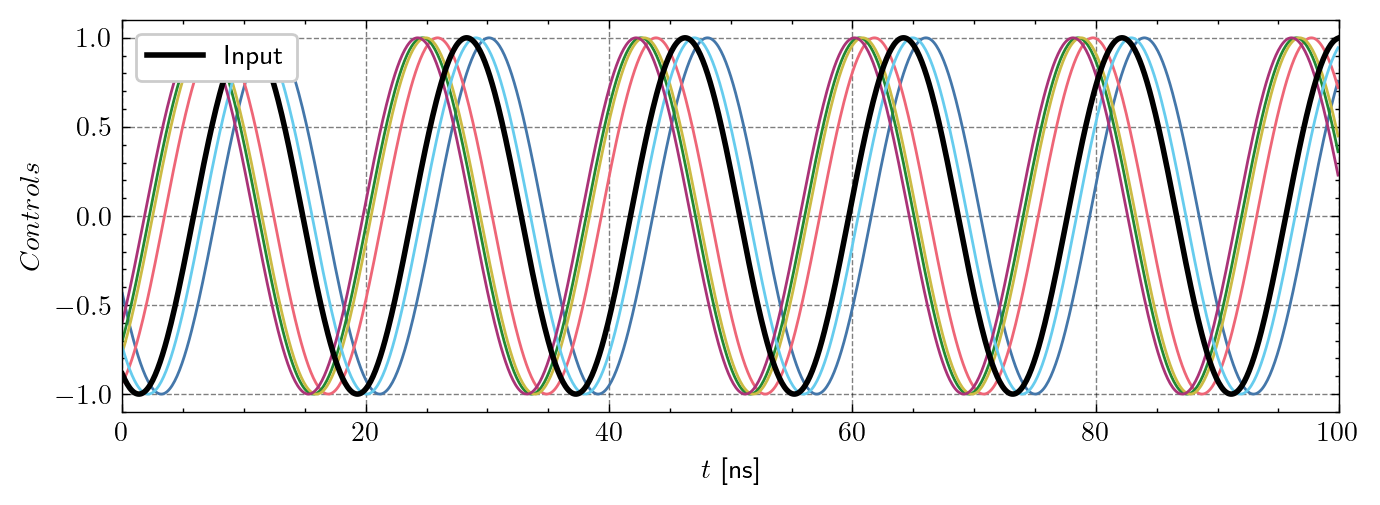

In [228]:
v = volt[min_val].iloc[-n_vals:,:].reset_index(drop=True)*1000
v = 2*(v - np.min(v))/(np.max(v)-np.min(v)) - 1

with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200, layout='tight')
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot()
    ax.plot(t, v)
    ax.plot(t, x, 'black', label='Input', lw=2)
    ax.set_ylabel("$Controls$")
    ax.set_xlabel("$t$ [ns]")
    ax.set_xlim(0,100)
    ax.legend(loc='upper left')

---